In [11]:
import pandas as pd
import numpy as np
import librosa
import glob
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import random

In [12]:
# メタデータの読み込み
train_master = pd.read_csv('train_master.csv', index_col=0) 
label_master = pd.read_csv('label_master.csv')
sample_submit = pd.read_csv('sample_submit.csv', header=None)

label_list = label_master.to_dict()['label_name']
print("ラベル:", label_list)
print("訓練データ数:", len(train_master))

ラベル: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
訓練データ数: 500


In [13]:
# データ拡張関数の定義
def add_white_noise(audio, noise_factor=0.005):
    """ホワイトノイズを追加"""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_shift(audio, shift_max=0.2):
    """時間軸方向のシフト"""
    shift = int(np.random.uniform(-shift_max, shift_max) *
len(audio))
    if shift > 0:
        augmented_audio = np.r_[audio[shift:], np.zeros(shift)]
    else:
        augmented_audio = np.r_[np.zeros(-shift), audio[:shift]]
    return augmented_audio

def time_stretch(audio, rate=None):
    """時間ストレッチ（速度変更）"""
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)  # 0.8倍から1.2倍の速度
    augmented_audio = librosa.effects.time_stretch(audio, rate=rate)
    return augmented_audio

def extract_mfcc_from_audio(audio, sr, n_mfcc=13, max_len=130):
    """音声データからMFCCを抽出"""
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # 固定長にパディング/トリミング
    if mfccs.shape[1] < max_len:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)),
mode='constant')
    else:
        mfccs = mfccs[:, :max_len]

    return mfccs

print("データ拡張関数を定義しました。")

データ拡張関数を定義しました。


In [ ]:
# 拡張された訓練データのMFCC特徴量を抽出
def extract_mfcc(file_path, n_mfcc=13, max_len=130):
    """MFCCを抽出し、固定長にする"""
    try:
        y, sr = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # 固定長にパディング/トリミング
        if mfccs.shape[1] < max_len:
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)),mode='constant')
        else:
            mfccs = mfccs[:, :max_len]

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 拡張された訓練データの作成
train_files = natsorted(glob.glob('train_sound*/train_*.au'))
print(f"元の訓練ファイル数: {len(train_files)}")

X_train_augmented = []
y_train_augmented = []

for i, file_path in enumerate(train_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(train_files)}")

    try:
        # 元の音声データを読み込み
        y, sr = librosa.load(file_path)
        file_index = int(file_path.split('_')[-1].split('.')[0])
        label = train_master.iloc[file_index]['label_id']

        # 1. 元のデータ
        mfccs_original = extract_mfcc_from_audio(y, sr)
        if mfccs_original is not None:
            X_train_augmented.append(mfccs_original)
            y_train_augmented.append(label)

        # 2. ホワイトノイズを追加
        y_noise = add_white_noise(y)
        mfccs_noise = extract_mfcc_from_audio(y_noise, sr)
        if mfccs_noise is not None:
            X_train_augmented.append(mfccs_noise)
            y_train_augmented.append(label)

        # 3. 時間シフト
        y_shift = time_shift(y)
        mfccs_shift = extract_mfcc_from_audio(y_shift, sr)
        if mfccs_shift is not None:
            X_train_augmented.append(mfccs_shift)
            y_train_augmented.append(label)

        # 4. 時間ストレッチ
        y_stretch = time_stretch(y)
        mfccs_stretch = extract_mfcc_from_audio(y_stretch, sr)
        if mfccs_stretch is not None:
            X_train_augmented.append(mfccs_stretch)
            y_train_augmented.append(label)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

X_train = np.array(X_train_augmented)
y_train = np.array(y_train_augmented)

print(f"拡張後の訓練データ形状: {X_train.shape}")
print(f"拡張後のラベル形状: {y_train.shape}")
print(f"データ拡張率: {len(y_train_augmented) / len(train_files):.1f}倍")

元の訓練ファイル数: 500
処理中: 0/500
処理中: 50/500
処理中: 100/500
処理中: 150/500
処理中: 200/500
処理中: 250/500
処理中: 300/500
処理中: 350/500
処理中: 400/500
処理中: 450/500
拡張後の訓練データ形状: (2000, 13, 130)
拡張後のラベル形状: (2000,)
データ拡張率: 4.0倍


In [15]:
# テストデータのMFCC特徴量を抽出
test_files = natsorted(glob.glob('test_sound*/test_*.au'))
print(f"テストファイル数: {len(test_files)}")

X_test = []

for i, file_path in enumerate(test_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(test_files)}")

    mfccs = extract_mfcc(file_path)
    if mfccs is not None:
        X_test.append(mfccs)

X_test = np.array(X_test)
print(f"テストデータ形状: {X_test.shape}")

テストファイル数: 500
処理中: 0/500
処理中: 50/500
処理中: 100/500
処理中: 150/500
処理中: 200/500
処理中: 250/500
処理中: 300/500
処理中: 350/500
処理中: 400/500
処理中: 450/500
テストデータ形状: (500, 13, 130)


In [16]:
# データの前処理
# CNNのために次元を追加（チャンネル次元）
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],
X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],
X_test.shape[2], 1)

# ラベルをone-hot encodingに変換
y_train_categorical = to_categorical(y_train, num_classes=10)

# 訓練データを訓練用と検証用に分割
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_categorical, test_size=0.2, random_state=42,stratify=y_train)

print(f"訓練データ形状: {X_train_split.shape}")
print(f"検証データ形状: {X_val_split.shape}")
print(f"テストデータ形状: {X_test.shape}")

訓練データ形状: (1600, 13, 130, 1)
検証データ形状: (400, 13, 130, 1)
テストデータ形状: (500, 13, 130, 1)


In [17]:
# 改良されたCNNモデルの構築（拡張データセット用）
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(13, 130, 1),
padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# モデルのコンパイル（学習率を調整）
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# モデルの構造を表示
model.summary()

/Users/kishi/Documents/ローカルコード/★データ分析/【練習問題】音楽ラベリング/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 130, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 130, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 65, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 65, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 65, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 65, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 32, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 32, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,642 (1.35 MB)

 Trainable params: 353,642 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# モデルの訓練（拡張データセット + コールバック）
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# コールバックの設定
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# モデルの訓練
history = model.fit(
    X_train_split, y_train_split,
    batch_size=64,  # バッチサイズを増加（拡張データが多いため）
    epochs=100,     # エポック数を増加
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(f"\\n拡張データセット訓練完了!")
print(f"訓練データ数: {len(X_train_split)}")
print(f"検証データ数: {len(X_val_split)}")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.0976 - loss: 2.6972 - val_accuracy: 0.1600 - val_loss: 2.2940 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.1202 - loss: 2.2885 - val_accuracy: 0.1850 - val_loss: 2.2117 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1795 - loss: 2.2179 - val_accuracy: 0.1725 - val_loss: 2.1663 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.1965 - loss: 2.1897 - val_accuracy: 0.2325 - val_loss: 2.0716 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2384 - loss: 2.0668 - val_accuracy: 0.2575 - val_loss: 2.0603 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2395 - loss: 2.0503 - val_accuracy: 0.3325 - val_loss: 1.9481 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2808 - loss: 1.9518 - 

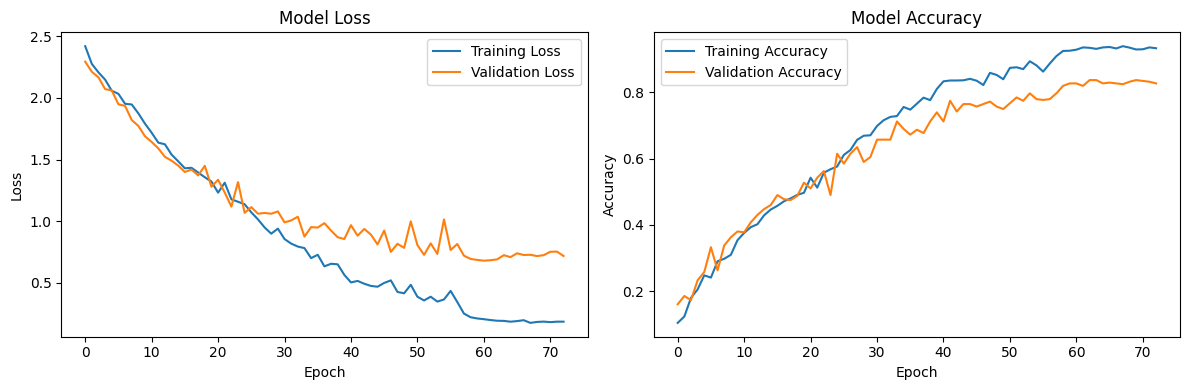

検証精度: 0.8375


In [20]:
# 訓練履歴の可視化
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 最終的な検証精度
val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split,
verbose=0)
print(f"検証精度: {val_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
分類レポート:
              precision    recall  f1-score   support

       blues       1.00      0.78      0.87        40
   classical       0.97      0.90      0.94        40
     country       0.88      0.75      0.81        40
       disco       0.51      0.88      0.65        40
      hiphop       0.82      0.82      0.82        40
        jazz       0.90      0.88      0.89        40
       metal       0.97      0.88      0.92        40
         pop       0.92      0.82      0.87        40
      reggae       0.95      0.93      0.94        40
        rock       0.75      0.75      0.75        40

    accuracy                           0.84       400
   macro avg       0.87      0.84      0.85       400
weighted avg       0.87      0.84      0.85       400



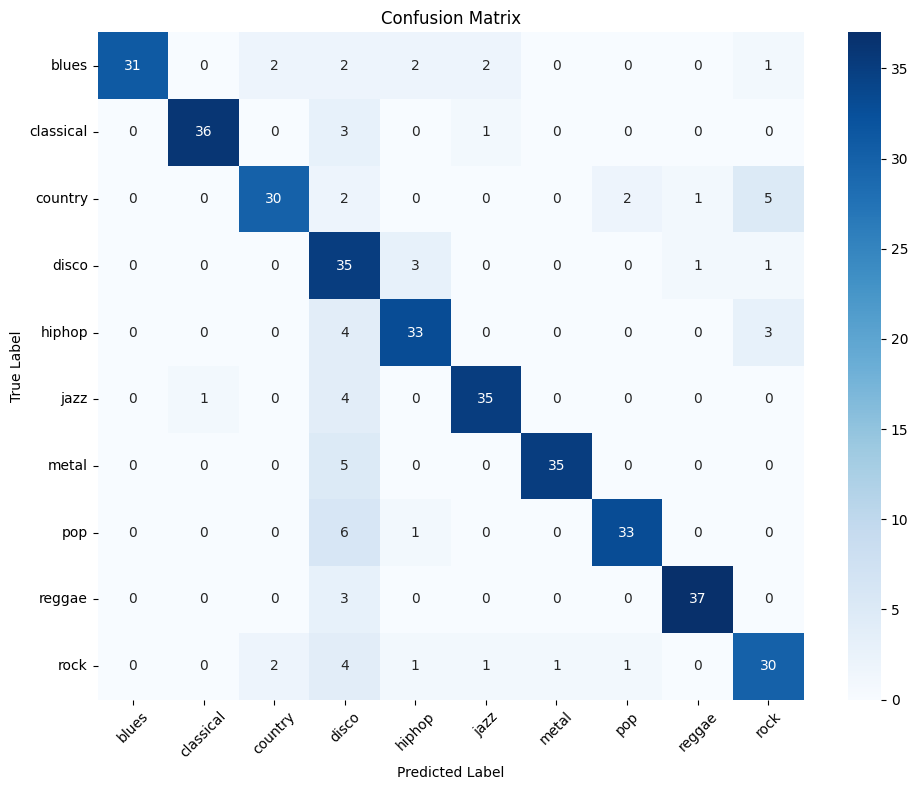

In [21]:
# 詳細な評価
y_pred = model.predict(X_val_split)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_split, axis=1)

# 分類レポート
print("分類レポート:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[label_list[i] for i in range(10)]))

# 混同行列
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[label_list[i] for i in range(10)], yticklabels=[label_list[i] for i in range(10)])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


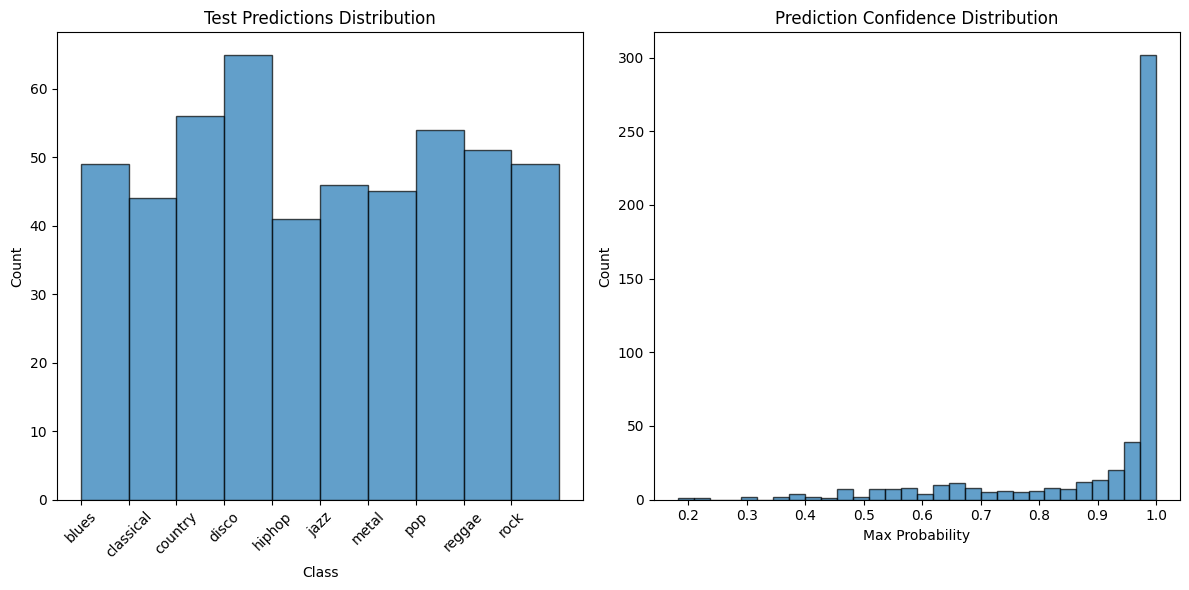

テストデータの予測完了: 500件
平均予測信頼度: 0.9025


In [22]:
# テストデータの予測
test_predictions = model.predict(X_test)
test_pred_classes = np.argmax(test_predictions, axis=1)

# 予測結果の確率分布を表示
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(test_pred_classes, bins=range(11), alpha=0.7, edgecolor='black')
plt.title('Test Predictions Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(10), [label_list[i] for i in range(10)], rotation=45)

# 予測の信頼度分布
plt.subplot(1, 2, 2)
max_probs = np.max(test_predictions, axis=1)
plt.hist(max_probs, bins=30, alpha=0.7, edgecolor='black')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Max Probability')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print(f"テストデータの予測完了: {len(test_pred_classes)}件")
print(f"平均予測信頼度: {np.mean(max_probs):.4f}")

In [23]:
# 結果をCSVファイルに保存
submission = pd.DataFrame({'id': sample_submit[0],'label_id': test_pred_classes})

submission.to_csv('submission_cnn_mfcc.csv', index=False, header=False)
print("予測結果をsubmission_cnn_mfcc.csvに保存しました")

# サンプル結果表示
print("\n予測結果の最初の10件:")
for i in range(10):
    print(f"Test {i}: {label_list[test_pred_classes[i]]} (信頼度: {max_probs[i]:.3f})")

予測結果をsubmission_cnn_mfcc.csvに保存しました

予測結果の最初の10件:
Test 0: pop (信頼度: 1.000)
Test 1: reggae (信頼度: 0.999)
Test 2: reggae (信頼度: 1.000)
Test 3: metal (信頼度: 1.000)
Test 4: classical (信頼度: 0.686)
Test 5: reggae (信頼度: 0.825)
Test 6: blues (信頼度: 0.999)
Test 7: reggae (信頼度: 1.000)
Test 8: jazz (信頼度: 1.000)
Test 9: blues (信頼度: 0.311)


In [24]:
# データ拡張の効果比較用の統計
print(f"\\n=== データ拡張効果の比較 ===")
print(f"拡張前のデータ数: 500")
print(f"拡張後のデータ数: {len(y_train)} (約{len(y_train)/500:.1f}倍)")
print(f"平均予測信頼度: {np.mean(max_probs):.4f}")

# 各クラスの予測数を表示
print(f"\\n=== クラス別予測数 ===")
for class_id in range(10):
    count = np.sum(test_pred_classes == class_id)
    print(f"{label_list[class_id]}: {count}件")

# サンプル結果表示
print("\\n=== 予測結果の最初の10件 ===")
for i in range(10):
    print(f"Test {i}: {label_list[test_pred_classes[i]]} (信頼度: {max_probs[i]:.3f})")

\n=== データ拡張効果の比較 ===
拡張前のデータ数: 500
拡張後のデータ数: 2000 (約4.0倍)
平均予測信頼度: 0.9025
\n=== クラス別予測数 ===
blues: 49件
classical: 44件
country: 56件
disco: 65件
hiphop: 41件
jazz: 46件
metal: 45件
pop: 54件
reggae: 51件
rock: 49件
\n=== 予測結果の最初の10件 ===
Test 0: pop (信頼度: 1.000)
Test 1: reggae (信頼度: 0.999)
Test 2: reggae (信頼度: 1.000)
Test 3: metal (信頼度: 1.000)
Test 4: classical (信頼度: 0.686)
Test 5: reggae (信頼度: 0.825)
Test 6: blues (信頼度: 0.999)
Test 7: reggae (信頼度: 1.000)
Test 8: jazz (信頼度: 1.000)
Test 9: blues (信頼度: 0.311)
